## Campbell - Financial Decisions and Markets - A course in Asset Pricing - Princeton Univesity Press (2017)

O intuito deste trabalho é replicar três tabelas para dados brasileiros do livro Financial Decisions and Markeets - A course in Asset Pricing de John Campbell (2017). São elas as Tabelas 6.1, 6.2 e 6.3.

In [22]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from datetime import datetime, timedelta
import pandas_datareader.data as web
from calendar import monthrange

### Tabela 6.1 
A tabela 6.1 reporta momentos básicos para retornos trimestrais em log de equity $r_e$ que para o caso brasileiro é usado os retornos do Ibovespa, taxa de juros de curto prazo em log $r_f$ que para o caso brasileiro é usado o futuro di de um mês, e taxa de crescimento do consumo per capita em log $\Delta c$, todos medidos em termos reais e base anualizada. Para cada variável a tabela tem três colunas reportando a média e desvio padrão ambos em pontos percentuais e a primeira autocorrelação.

### Inflação

In [3]:
# criando um dataframe com as datas diárias e com frequência trimestral de 01/01/2000 até hoje
date_today = datetime.now().date()
days = pd.date_range(start = '2000-01-01', end = date_today, freq='D')
months = pd.date_range(start = '2012-06-30', end = date_today, freq='M')
quarters = pd.date_range(start = '2012-06-30', end = date_today, freq='Q')

In [4]:
# função que se a entrada for NaN toma o valor do dia anterior
def normalize_nan(df):
    for i in range(len(df)):
        if i == 0:
            pass
        elif math.isnan(df.iloc[i]) == True:
            df.iloc[i] = df.iloc[i-1]
        else:
            continue

In [5]:
# função que recebe código do BC e devolve uma série de acordo
# códigos e séries podem ser encontrados em https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [6]:
ipca = pd.DataFrame(consulta_bc(433), index=days)

In [7]:
normalize_nan(ipca)

In [8]:
# transformando os dados em decimais
ipca = ipca/100

In [9]:
ipca = ipca.loc[months]

In [10]:
ipca['valor_{t-1}'] = ipca['valor'].shift(1)
ipca['valor_{t-2}'] = ipca['valor'].shift(2)

Para obter a inflação e tornar as séries reais utilizaremos o Índice de Preços do Consumidor Amplo (IPCA). Como a periodicidade é trimestral, também será necessário tornar o IPCA trimestral $\pi_{\Delta t}$. Como o IPCA é um dado mensal $\pi_t$, podemos obte-lô de forma trimestral a partir da seguinte equação

$$
\pi_{\Delta t} = (1+\pi_t)\cdot(1+\pi_{t-1})\cdot(1+\pi_{t-2}) - 1
$$

In [11]:
ipca['IPCA_trimestral'] = (1+ipca['valor'])*(1+ipca['valor_{t-1}'])*(1+ipca['valor_{t-2}']) - 1

In [12]:
ipca = ipca.loc[quarters]

In [13]:
ipca.head(10)

,valor,valor_{t-1},valor_{t-2},IPCA_trimestral
2012-06-30,0.0008,NaN,NaN,NaN
2012-09-30,0.0057,0.0041,0.0043,0.014166
2012-12-31,0.0079,0.0060,0.0059,0.019930
2013-03-31,0.0047,0.0060,0.0086,0.019420
2013-06-30,0.0026,0.0037,0.0055,0.011844
2013-09-30,0.0035,0.0024,0.0003,0.006210
2013-12-31,0.0092,0.0054,0.0057,0.020433
2014-03-31,0.0092,0.0069,0.0055,0.021752
2014-06-30,0.0040,0.0046,0.0067,0.015376
2014-09-30,0.0057,0.0025,0.0001,0.008315


Precisamos ainda, anualizar o IPCA

$$
\pi_{\Delta t}^{anualizado} = (1+\pi_{\Delta t})^4 - 1
$$

In [14]:
ipca['IPCA_a'] = (1+ipca['IPCA_trimestral'])**4 - 1

In [15]:
ipca.head(10)

,valor,valor_{t-1},valor_{t-2},IPCA_trimestral,IPCA_a
2012-06-30,0.0008,NaN,NaN,NaN,NaN
2012-09-30,0.0057,0.0041,0.0043,0.014166,0.057878
2012-12-31,0.0079,0.0060,0.0059,0.019930,0.082134
2013-03-31,0.0047,0.0060,0.0086,0.019420,0.079974
2013-06-30,0.0026,0.0037,0.0055,0.011844,0.048226
2013-09-30,0.0035,0.0024,0.0003,0.006210,0.025073
2013-12-31,0.0092,0.0054,0.0057,0.020433,0.084272
2014-03-31,0.0092,0.0069,0.0055,0.021752,0.089890
2014-06-30,0.0040,0.0046,0.0067,0.015376,0.062938
2014-09-30,0.0057,0.0025,0.0001,0.008315,0.033677


### Ibovespa

In [16]:
ibov = web.get_data_yahoo('^BVSP', start = "2000-01-01")
ibov = pd.DataFrame(data = ibov['Adj Close'], index = days)
ibov = ibov.rename(columns={'Adj Close': 'IBOV'})

In [29]:
normalize_nan(ibov)

In [31]:
# visualização melhor de gráficos
sns.set(rc={'figure.figsize':(12,8)});

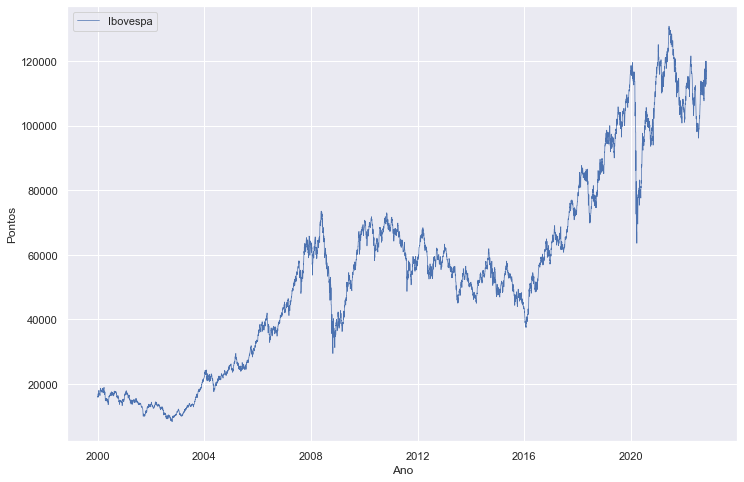

In [32]:
# Série do Ibovespa graficamente
plt.plot(ibov['IBOV'], label = 'Ibovespa', linewidth =.7)
plt.xlabel("Ano")
plt.ylabel("Pontos")
plt.xticks(fontname = "Arial")
plt.legend()
plt.show()

In [33]:
# vai retornar o dataframe do ibovespa com valores trimestrais apenas
ibov = ibov.loc[quarters]

Os retornos trimestrais anualizados do Ibovespa podem ser obtidos através da seguinte equação

$$
r_e = \left[1+\ln\left(\frac{P_{t}}{P_{t-1}}\right)\right]^4-1
$$

In [34]:
ibov['IBOV_{t-1}'] = ibov['IBOV'].shift(1)

In [35]:
ibov['re'] = (1 + (np.log(ibov['IBOV']/ibov['IBOV_{t-1}'])))**4 - 1

In [36]:
ibov.head(10)

,IBOV,IBOV_{t-1},re
2012-06-30,54355.0,NaN,NaN
2012-09-30,59176.0,54355.0,0.385754
2012-12-31,60952.0,59176.0,0.123633
2013-03-31,56352.0,60952.0,-0.278826
2013-06-30,47457.0,56352.0,-0.529506
2013-09-30,52338.0,47457.0,0.452944
2013-12-31,51507.0,52338.0,-0.062499
2014-03-31,50415.0,51507.0,-0.083000
2014-06-30,53168.0,50415.0,0.230242
2014-09-30,54116.0,53168.0,0.072589


In [37]:
ibov['IPCA'] = ipca['IPCA_a']

Para obtermos a rentabilidade da equity em termos reais temos que

$$
r_e^{\$} = \frac{1+r_e}{1+\pi} - 1
$$

In [38]:
ibov['re_real'] = ((1+ibov['re'])/(1+ibov['IPCA'])) - 1

In [39]:
ibov = ibov[:-1]

In [40]:
ibov.head(10)

,IBOV,IBOV_{t-1},re,IPCA,re_real
2012-06-30,54355.0,NaN,NaN,NaN,NaN
2012-09-30,59176.0,54355.0,0.385754,0.057878,0.309937
2012-12-31,60952.0,59176.0,0.123633,0.082134,0.038350
2013-03-31,56352.0,60952.0,-0.278826,0.079974,-0.332231
2013-06-30,47457.0,56352.0,-0.529506,0.048226,-0.551152
2013-09-30,52338.0,47457.0,0.452944,0.025073,0.417406
2013-12-31,51507.0,52338.0,-0.062499,0.084272,-0.135364
2014-03-31,50415.0,51507.0,-0.083000,0.089890,-0.158630
2014-06-30,53168.0,50415.0,0.230242,0.062938,0.157398
2014-09-30,54116.0,53168.0,0.072589,0.033677,0.037644


### Futuro DI com um mês

In [41]:
futurodi = pd.read_csv('futuroDI.csv', sep=',', index_col=0)

In [42]:
# função que torna o índice um objeto de data
futurodi.index = pd.to_datetime(futurodi.index)

In [43]:
# normalizando os dados que estavam em taxas para números decimais
futurodi = futurodi/100

In [44]:
futurodi = futurodi[['BRPRE1M=BMF']]

In [45]:
futurodi = futurodi.rename(columns={'BRPRE1M=BMF':'rf'})

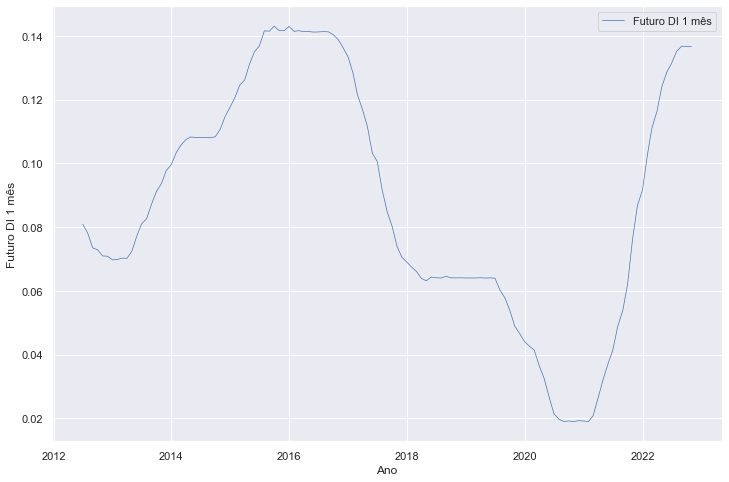

In [47]:
# Série do futuro DI graficamente
plt.plot(futurodi['rf'], label = 'Futuro DI 1 mês', linewidth =.7)
plt.xlabel("Ano")
plt.ylabel("Futuro DI 1 mês")
plt.xticks(fontname = "Arial")
plt.legend()
plt.show()

In [48]:
futurodi = futurodi[::-1]

In [49]:
futurodi = futurodi.loc[quarters]

In [50]:
futurodi.head(10)

,rf
2012-06-30,0.08089
2012-09-30,0.07293
2012-12-31,0.06974
2013-03-31,0.07021
2013-06-30,0.08104
2013-09-30,0.09118
2013-12-31,0.09957
2014-03-31,0.10743
2014-06-30,0.10814
2014-09-30,0.10835


In [51]:
futurodi['IPCA'] = ipca['IPCA_a']

Da mesma forma para o short-term interest rate, para obtermos a rentabilidade em termos reais temos que

$$
r_f^{\$} = \frac{1+r_f}{1+\pi} - 1
$$

In [52]:
futurodi['rf_real'] = ((1+futurodi['rf'])/(1+futurodi['IPCA'])) - 1

In [53]:
futurodi = futurodi[:-1]

In [54]:
futurodi.head(10)

,rf,IPCA,rf_real
2012-06-30,0.08089,NaN,NaN
2012-09-30,0.07293,0.057878,0.014229
2012-12-31,0.06974,0.082134,-0.011453
2013-03-31,0.07021,0.079974,-0.009041
2013-06-30,0.08104,0.048226,0.031305
2013-09-30,0.09118,0.025073,0.064490
2013-12-31,0.09957,0.084272,0.014109
2014-03-31,0.10743,0.089890,0.016093
2014-06-30,0.10814,0.062938,0.042526
2014-09-30,0.10835,0.033677,0.072240


### Consumo Real per capita Desazonalizado

In [55]:
consumo = pd.read_csv('real_consumption_seasonally_adjusted.csv', sep=',', index_col=0)
pop = pd.read_csv('population.csv', sep=',', index_col=0)

In [56]:
# função que torna o índice um objeto de data
consumo.index = pd.to_datetime(consumo.index)
pop.index = pd.to_datetime(pop.index)

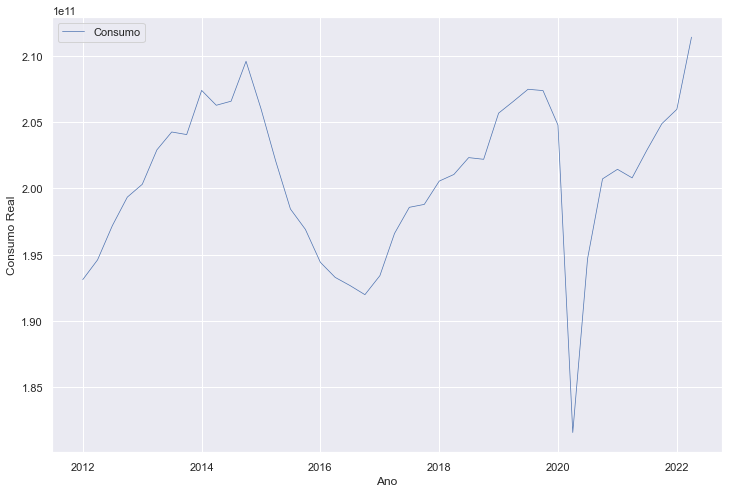

In [58]:
# Série do Consumo graficamente
plt.plot(consumo['NAEXKP02BRQ189S'], label = 'Consumo', linewidth =.7)
plt.xlabel("Ano")
plt.ylabel("Consumo Real")
plt.xticks(fontname = "Arial")
plt.legend()
plt.show()

In [ ]:
quarters_ = consumo.index

In [ ]:
pop = pd.DataFrame(pop, index = quarters_)

In [ ]:
pop.head(10)

,POPTOTBRA647NWDB
DATE,
2012-01-01,199287292.0
2012-04-01,NaN
2012-07-01,NaN
2012-10-01,NaN
2013-01-01,201035904.0
2013-04-01,NaN
2013-07-01,NaN
2013-10-01,NaN
2014-01-01,202763744.0


Como os dados de população são ofertados apenas com periodicidade anual, vamos supor que o crescimento trimestral $\Delta L_t / L_t$ foi uniforme, isto é, mesma taxa de crescimento entre os trimestres:

$$
\frac{\Delta L_{t}}{L_t} = \left(1+\frac{\Delta L_{4t}}{L_{4t}}\right)^{\frac{1}{4}} - 1
$$

onde 

$$
\frac{\Delta L_{4t}}{L_{4t}}
$$

é a taxa de crescimento populacional anual.

Uma outra ressalva é que os dados populacionais vão até o primeiro trimestre de 2021. Teremos então que a população estimada para os trimestres posteriores serão a partir da taxa de crescimento entre 2020 e 2021 e a população constatada em 2021.

In [ ]:
pop['POP_{t-1}'] = pop['POPTOTBRA647NWDB'].shift(4)

In [ ]:
pop['taxa_anual'] = (pop['POPTOTBRA647NWDB'] - pop['POP_{t-1}'])/pop['POP_{t-1}']

In [ ]:
pop['taxa_trimestral'] = np.nan

In [ ]:
for i in range(len(pop)):
    if math.isnan(pop['taxa_anual'][i]) == False:
        pop['taxa_trimestral'][i-1] = (1 + pop['taxa_anual'][i])**(1/4) - 1        
        pop['taxa_trimestral'][i-2] = (1 + pop['taxa_anual'][i])**(1/4) - 1
        pop['taxa_trimestral'][i-3] = (1 + pop['taxa_anual'][i])**(1/4) - 1
        pop['taxa_trimestral'][i-4] = (1 + pop['taxa_anual'][i])**(1/4) - 1
    else:
        continue

In [ ]:
normalize_nan(pop['taxa_trimestral'])

In [ ]:
pop['pop_estimada'] = np.nan

In [ ]:
for i in range(len(pop)):
    if math.isnan(pop['POPTOTBRA647NWDB'][i]) == False:
        pop['pop_estimada'][i] = pop['POPTOTBRA647NWDB'][i]
    else:
        pop['pop_estimada'][i] = pop['pop_estimada'][i-1]*(1+pop['taxa_trimestral'][i-1])

In [ ]:
pop.head(10)

,POPTOTBRA647NWDB,POP_{t-1},taxa_anual,taxa_trimestral,pop_estimada
DATE,,,,,
2012-01-01,199287292.0,NaN,NaN,0.002186,1.992873e+08
2012-04-01,NaN,NaN,NaN,0.002186,1.997230e+08
2012-07-01,NaN,NaN,NaN,0.002186,2.001597e+08
2012-10-01,NaN,NaN,NaN,0.002186,2.005973e+08
2013-01-01,201035904.0,199287292.0,0.008774,0.002142,2.010359e+08
2013-04-01,NaN,NaN,NaN,0.002142,2.014665e+08
2013-07-01,NaN,NaN,NaN,0.002142,2.018980e+08
2013-10-01,NaN,NaN,NaN,0.002142,2.023304e+08
2014-01-01,202763744.0,201035904.0,0.008595,0.002099,2.027637e+08


In [ ]:
consumo['pop'] = pop['pop_estimada']

In [ ]:
consumo['consumo_percapita'] = consumo['NAEXKP02BRQ189S']/consumo['pop']

A taxa de crescimento do consumo pode ser obtida através de

$$
\Delta c_t = \ln\left(\frac{C_t}{C_{t-1}}\right)
$$

In [ ]:
consumo['consumo_percapita_{t-1}'] = consumo['consumo_percapita'].shift(1)

In [ ]:
consumo['Delta_c'] = np.log(consumo['consumo_percapita']/consumo['consumo_percapita_{t-1}'])

Como 2012-04-01 representa o consumo no segundo trimetre de 2012 no dataframe de consumo e 2012-06-30 representa o fechamento do Ibovespa do segundo trimestre de 2012. Então temos que as datas estão representando períodos diferentes entre os dataframes. Vamos normalizar isso

In [ ]:
consumo = consumo[1:]

In [ ]:
# normalizando o índice para os três dataframes ficarem iguais
consumo['index'] = ibov.index

In [ ]:
consumo = consumo.set_index('index')

In [ ]:
consumo.head(10)

,NAEXKP02BRQ189S,pop,consumo_percapita,consumo_percapita_{t-1},Delta_c
index,,,,,
2012-06-30,1.946165e+11,1.997230e+08,974.432202,969.080023,0.005508
2012-09-30,1.971950e+11,2.001597e+08,985.188204,974.432202,0.010978
2012-12-31,1.993447e+11,2.005973e+08,993.755424,985.188204,0.008658
2013-03-31,2.003120e+11,2.010359e+08,996.399101,993.755424,0.002657
2013-06-30,2.029082e+11,2.014665e+08,1007.156136,996.399101,0.010738
2013-09-30,2.042542e+11,2.018980e+08,1011.670265,1007.156136,0.004472
2013-12-31,2.040599e+11,2.023304e+08,1008.547673,1011.670265,-0.003091
2014-03-31,2.073897e+11,2.027637e+08,1022.814570,1008.547673,0.014047
2014-06-30,2.062680e+11,2.031894e+08,1015.151529,1022.814570,-0.007520


### DataFrame final

In [ ]:
df = pd.DataFrame(index = ibov.index)

In [ ]:
df['r_e'] = ibov['re_real']
df['r_f'] = futurodi['rf_real']
df['Delta_c'] = consumo['Delta_c']

In [ ]:
df.head(10)

,r_e,r_f,Delta_c
2012-06-30,NaN,NaN,0.005508
2012-09-30,0.309937,0.014229,0.010978
2012-12-31,0.038350,-0.011453,0.008658
2013-03-31,-0.332231,-0.009041,0.002657
2013-06-30,-0.551152,0.031305,0.010738
2013-09-30,0.417406,0.064490,0.004472
2013-12-31,-0.135364,0.014109,-0.003091
2014-03-31,-0.158630,0.016093,0.014047
2014-06-30,0.157398,0.042526,-0.007520
2014-09-30,0.037644,0.072240,-0.000611


#### Construção da Tabela 6.1

In [ ]:
# teremos que re é o retorno real do ibovespa, rf o retorno real do ativo livre de risco e c representa a taxa de crescimento real do consumo per capita
# mean(), std() e ro() representam respectivamente, os operadores da média, desvio padrão e coeficiente de autocorrelação com uma defasagem
Tabela_6_1 = pd.DataFrame(
    columns=['sample period', 'mean(re)', 'std(re)', 'ro(re)', 'mean(rf)', 'std(rf)', 'ro(rf)', 'mean(c)', 'std(c)', 'ro(c)'],
    index = ['Brazil']
)

In [ ]:
# Período dos dados
Tabela_6_1['sample period'] = '2012Q2-2022Q2'

In [ ]:
# dados do re
Tabela_6_1['mean(re)'] = df['r_e'].mean()*100
Tabela_6_1['std(re)'] = df['r_e'].std()*100
Tabela_6_1['ro(re)'] = df['r_e'].autocorr(lag=1)

In [ ]:
# dados do rf
Tabela_6_1['mean(rf)'] = df['r_f'].mean()*100
Tabela_6_1['std(rf)'] = df['r_f'].std()*100
Tabela_6_1['ro(rf)'] = df['r_f'].autocorr(lag=1)

In [ ]:
# dados consumo
Tabela_6_1['mean(c)'] = df['Delta_c'].mean()*100
Tabela_6_1['std(c)'] = df['Delta_c'].std()*100
Tabela_6_1['ro(c)'] = df['Delta_c'].autocorr(lag=1)

In [ ]:
Tabela_6_1

,sample period,mean(re),std(re),ro(re),mean(rf),std(rf),ro(rf),mean(c),std(c),ro(c)
Brazil,2012Q2-2022Q2,8.842032,47.78769,-0.351141,2.149962,4.464304,0.601206,0.026364,2.466657,-0.124133


### Tabela 6.2 - The equity premium puzzle
Nesta tabela serão computados o arithmetic average excess stock return $aer_e$, o desvio padrão do excesso de retorno das ações em log $\sigma (er_e)$, o limite inferior de $\sigma(\ln(M_{t+1,t}))$ denotado por $\sigma(m)$, desvio padrão da taxa de crescimento do consumo $\sigma(\Delta c)$ que foi computada na Tabela 6.1, o coefiente correlação entre as séries de excesso de retorno das ações e taxa de crescimento do consumo $\rho(er_e,\Delta c)$. Por fim, são apresentados por dois métodos diferentes a estimação do coeficiente de aversão relativa ao risco $RRA(1)$ e $RRA(2)$ (Relative Risk Aversion), respectivamente.

Assumindo que o consumidor representativo tem utilidade separável no tempo do tipo CRRA (Constant Relative Risk Aversion) como se segue

$$
U_i(c) = \mathbb{E}\left(\sum_{t=0}^T \beta^t \frac{C_t^{1-\gamma} - 1}{1-\gamma}\right)
$$

Após a derivação do fator estocástico de desconto chegamos que

$$
M_{t+1,t} = \frac{\pi_{t+1}}{\pi_t} = \beta \frac{u_i'(C_{t+1})}{u_i'(C_t)}
$$

Portanto,

$$
M_{t+1,t} = \beta \left(\frac{C_{t+1}}{C_t}\right)^{-\gamma}
$$

Aplicando o logaritmo neperiano $\ln(\cdot)$ e definindo $m_{t+1,t} = \ln(M_{t+1,t})$ e $\Delta c_{t+1} = \ln\left(\frac{C_{t+1}}{C_t}\right)$

$$
m_{t+1,t} = \ln(\beta) - \gamma \Delta c_{t+1} \tag{1}
$$

Partindo do Valor Presente Descontado sob ausência de arbitragem

$$
\mathbb{E}_t[M_{t+1,t} R_{t+1}^j] = 1
$$

$$
\ln(\mathbb{E}_t[M_{t+1,t} R_{t+1}^j]) = \ln(1) = 0
$$

$$
\ln(\mathbb{E}_t[\exp(\ln(M_{t+1,t} R_{t+1}^j))]) = 0
$$

$$
\ln(\mathbb{E}_t[\exp(\ln(M_{t+1,t}) + \ln(R_{t+1}^j))]) = 0
$$

Como $m_{t+1,t} = \ln(M_{t+1,t})$ e também $r_{t+1}^j \approx \ln(R_{t+1}^j)$
$$
\ln(\mathbb{E}_t[\exp(m_{t+1,t} + r_{t+1}^j)]) = 0
$$

onde $\mathbb{E}_t[\exp(m_{t+1,t} + r_{t+1}^j)]$ nada mais é do que a função geradora de momentos de $m_{t+1,t} + r_{t+1}^j$ para $t=1$

$$
M_X (t) = \mathbb{E}[e^{tX}]
$$

Sob a hipótese de lognormalidade homocedástica do fator estocástico de desconto e dos retornos

$$
\ln(M_{t+1,t} R_{t+1}^j) \sim N(\cdot) \Leftrightarrow m_{t+1,t} + r_{t+1}^j \sim N(\cdot)
$$


Uma propriedade de uma variável aleatória distribuída normalmente $X \sim N(\mu,\sigma^2)$ é que sua função geradora de momentos é 

$$
M_X (t) = \mathbb{E}[e^{tX}] = \exp(\mu t + \frac{\sigma^2}{2} t^2)
$$

Portanto

$$
\ln(\mathbb{E}_t[\exp(m_{t+1,t} + r_{t+1}^j)]) = 0
$$

$$
\ln(\exp(\mathbb{E}[m_{t+1,t} + r_{t+1}^j] + \frac{1}{2} \mathbb{V}[m_{t+1,t} + r_{t+1}^j])) = 0
$$

$$
\mathbb{E}[m_{t+1,t} + r_{t+1}^j] + \frac{1}{2}\left(\mathbb{V}[m_{t+1,t}] + \mathbb{V}[r_{t+1}^j] + 2\mathbb{C}[m_{t+1,t},r_{t+1}^j]\right) = 0 
\tag{2}
$$

Substituindo $(1)$ em $(2)$, temos

$$
\mathbb{E}[r_{t+1}^j] + \ln(\beta) -\gamma\mathbb{E}[\Delta c_{t+1}] + \frac{1}{2}\left(\mathbb{V}[r_{t+1}^j] + \gamma^2\mathbb{V}[\Delta c_{t+1}] - 2\gamma\mathbb{C}[\Delta c_{t+1},r_{t+1}^j]\right) = 0 
\tag{3}
$$

Para um ativo livre de risco $j$ defina seu retorno por $\mathbb{E}[r_{t+1}^j] = r_c^{t\rightarrow t+1}$. Para esse ativo temos as seguintes propriedades 

$$
\mathbb{V}[r_{t+1}^j] = 0 
$$

$$
\mathbb{C}[m_{t+1,t}, r_{t+1}^j] = 0
$$

A equação $(2)$ se torna

$$
\mathbb{E}[m_{t+1,t}] + r_c^{t\rightarrow t+1} + \frac{1}{2}\mathbb{V}[m_{t+1,t}] = 0 
$$

$$
r_c^{t\rightarrow t+1} + \ln(\beta) - \gamma\mathbb{E}[\Delta c_{t+1}] +\frac{1}{2}\gamma^2\mathbb{V}[\Delta c_{t+1}] = 0
\tag{4}
$$

Para encontra o Log do prêmio de risco basta subtrair $(4)$ de $(3)$ e teremos

$$
\mathbb{E}[r_{t+1}^j] - r_c^{t\rightarrow t+1} + \frac{1}{2}\mathbb{V}[r_{t+1}^j] -\gamma\mathbb{C}[\Delta c_{t+1},r_{t+1}^j] = 0
$$

$$
\mathbb{E}[r_{t+1}^j] - r_c^{t\rightarrow t+1} + \frac{1}{2}\mathbb{V}[r_{t+1}^j] = \gamma\mathbb{C}[\Delta c_{t+1},r_{t+1}^j]
\tag{5}
$$

conhecido como aritmethic average excess return

In [ ]:
# aer_e é o aritmethic average excess return, er_e é o excess return, std(m) é o lower bound do desvio padrão do ln do fator estocástico
# c representa a taxa de crescimento do consumo, RRA(1) e RRA(2) são respectivamente, a aversão relativa ao risco extraída do prêmio de risco e a aversão ao risco relativa
Tabela_6_2 = pd.DataFrame(
    columns=['sample period', 'mean(aer_e)', 'std(er_e)', 'std(m)', 'std(c)', 'ro(er_e,c)', 'RRA(1)', 'RRA(2)'],
    index = ['Brazil']
)

In [ ]:
# Período dos dados
Tabela_6_2['sample period'] = '2012Q2-2022Q2'

In [ ]:
Tabela_6_2['mean(aer_e)'] = Tabela_6_1['mean(re)'] - Tabela_6_1['mean(rf)'] + (1/2)*((Tabela_6_1['std(re)']/100)**2)*100

Para definir o excesso de retorno das ações em log $er_e$, basta apenas

$$
er_e = r_e - r_f
$$

In [ ]:
df['er_e'] = df['r_e'] - df['r_f']

In [ ]:
df.head(10)

,r_e,r_f,Delta_c,er_e
2012-06-30,NaN,NaN,0.005508,NaN
2012-09-30,0.309937,0.014229,0.010978,0.295709
2012-12-31,0.038350,-0.011453,0.008658,0.049803
2013-03-31,-0.332231,-0.009041,0.002657,-0.323189
2013-06-30,-0.551152,0.031305,0.010738,-0.582457
2013-09-30,0.417406,0.064490,0.004472,0.352916
2013-12-31,-0.135364,0.014109,-0.003091,-0.149473
2014-03-31,-0.158630,0.016093,0.014047,-0.174724
2014-06-30,0.157398,0.042526,-0.007520,0.114872
2014-09-30,0.037644,0.072240,-0.000611,-0.034596


Basta agora, encontrar o desvio padrão do excesso de retorno $dp(er_e)$

In [ ]:
Tabela_6_2['std(er_e)'] = df['er_e'].std()*100

Para encontrar o limite inferior de $m_{t+1,t}$ vamos usar o fato de que $\rho(\cdot) \in [-1,1]$ onde $\rho(\cdot)$ representa o operador de correlação

$$
\rho[m_{t+1,t}, r_{t+1}^j] = \frac{\mathbb{C}[m_{t+1,t}, r_{t+1}^j]}{\mathbb{dp}[m_{t+1,t}]\mathbb{dp}[r_{t+1}^j]} \geq -1
$$

$$
\frac{\mathbb{C}[m_{t+1,t}, r_{t+1}^j]}{\mathbb{dp}[r_{t+1}^j]} \geq -\mathbb{dp}[m_{t+1,t}]
$$

$$
\mathbb{dp}[m_{t+1,t}] \geq -\frac{\mathbb{C}[m_{t+1,t}, r_{t+1}^j]}{\mathbb{dp}[r_{t+1}^j]}
$$

Como

$$
\mathbb{C}[m_{t+1,t},r_{t+1}^j] = -\gamma\mathbb{C}[\Delta c_{t+1}, r_{t+1}^j]
$$

Portanto

$$
\mathbb{dp}[m_{t+1,t}] \geq \frac{\gamma\mathbb{C}[\Delta c_{t+1}, r_{t+1}^j]}{\mathbb{dp}[r_{t+1}^j]}
$$

Usando $(5)$

$$
\mathbb{dp}[m_{t+1,t}] \geq \frac{\mathbb{E}[r_{t+1}^j] - r_c^{t\rightarrow t+1} + \frac{1}{2}\mathbb{V}[r_{t+1}^j]}{\mathbb{dp}[r_{t+1}^j]}
\tag{6}
$$

chegamos no limite inferior de $dp(\ln(M_{t+1,t}))$. Denote esse limite por

$$
\sigma(m) = \frac{\mathbb{E}[r_{t+1}^j] - r_c^{t\rightarrow t+1} + \frac{1}{2}\mathbb{V}[r_{t+1}^j]}{\mathbb{dp}[r_{t+1}^j]}
$$

In [ ]:
# ambas medidas mean(aer_e) e std(re) estão multiplicadas por 100 para expressar em %, na fração isso se anula e então multiplicamos por 100 para std(m) ficar em % também
Tabela_6_2['std(m)'] = (Tabela_6_2['mean(aer_e)']/Tabela_6_1['std(re)'])*100

A coluna do desvio padrão da taxa de crescimento do consumo foi obtida na Tabela 6.1.

In [ ]:
Tabela_6_2['std(c)'] = Tabela_6_1['std(c)']

Um dos dados que é demonstrado na Tabela 6.2 e será necessário para obter o coeficiente de aversão relativa ao risco pelo segundo método $RRA(2)$ é o coeficiente de correlação entre o excesso de retorno e a taxa de crescimento do consumo

$$
\rho[er_e,\Delta c] = \frac{\mathbb{C}[er_e, \Delta c]}{dp[er_e]\cdot dp[\Delta c]}
$$

In [ ]:
Tabela_6_2['ro(er_e,c)'] = df['Delta_c'].corr(df['er_e'])

Partindo da equação $(5)$

$$
\gamma = \frac{\mathbb{E}[r_{t+1}^j] - r_c^{t\rightarrow t+1} + \frac{1}{2}\mathbb{V}[r_{t+1}^j]}{\mathbb{C}[\Delta c_{t+1},r_{t+1}^j]}
$$

denote por $RRA(1)$ o coeficiente de aversão relativa ao risco extraído do prêmio de risco
e 

$$
RRA(2) = \rho[er_e, \Delta c]\cdot RRA(1)
$$

In [ ]:
# mean(aer_e) está em %, então precisamos dividir por 100 para que ambos numerador e denominador fiquem na mesma unidade de medida
Tabela_6_2['RRA(1)'] = (Tabela_6_2['mean(aer_e)']/100)/(df['Delta_c'].cov(df['r_e']))

In [ ]:
Tabela_6_2['RRA(2)'] = Tabela_6_2['RRA(1)']*Tabela_6_2['ro(er_e,c)']

In [ ]:
Tabela_6_2

,sample period,mean(aer_e),std(er_e),std(m),std(c),"ro(er_e,c)",RRA(1),RRA(2)
Brazil,2012Q2-2022Q2,18.110386,47.790913,37.897597,2.466657,-0.345461,-41.299024,14.267194


### Tabela 6.3 - The riskfree rate puzzle
A Tabela 6.3 trás as colunas já obtidas nas Tabelas anteriores da média do retorno do ativo livre de risco, a média da taxa de crescimento do consumo em log, o desvio padrão da taxa de crescimento do consumo e os dois coeficientes de aversão relativa ao risco RRA(1) e RRA(2). De novo, apenas as colunas de taxa de preferência intertemporal TPR(1) e TPR(2) (Time Preference Rate). O modelo de utilidade na potência tem um parâmetro livre, o fator de disconto temporal $\beta$, que pode ser usado para ajustar a média da taxa de juros livre de risco. a taxa de preferência intertemporal, $-\ln(\beta)$, é a taxa de juros real livre de risco que seria observada em uma economia hipotética sem crescimento ou incerteza.

In [ ]:
Tabela_6_3 = pd.DataFrame(
    columns=['sample period', 'mean(r_f)', 'mean(c)', 'std(c)', 'RRA(1)', 'TPR(1)', 'RRA(2)', 'TPR(2)'],
    index = ['Brazil']
)

In [ ]:
# Período dos dados
Tabela_6_3['sample period'] = '2012Q2-2022Q2'

In [ ]:
Tabela_6_3['mean(r_f)'] = Tabela_6_1['mean(rf)']
Tabela_6_3['mean(c)'] = Tabela_6_1['mean(c)']
Tabela_6_3['std(c)'] = Tabela_6_1['std(c)']
Tabela_6_3['RRA(1)'] = Tabela_6_2['RRA(1)']
Tabela_6_3['RRA(2)'] = Tabela_6_2['RRA(2)']

Da equação $(4)$ temos


$$
r_c^{t\rightarrow t+1} + \ln(\beta) - \gamma\mathbb{E}[\Delta c_{t+1}] +\frac{1}{2}\gamma^2\mathbb{V}[\Delta c_{t+1}] = 0
$$

$$
- \ln(\beta) = r_c^{t\rightarrow t+1} - \gamma\mathbb{E}[\Delta c_{t+1}] +\frac{1}{2}\gamma^2\mathbb{V}[\Delta c_{t+1}]
$$

Como $\gamma$ é obtido por dois métodos $RRA(1)$ e $RRA(2)$, temos então duas taxas de preferência intertemporal $TPR(1)$ e $TPR(2)$.

In [ ]:
Tabela_6_3['TPR(1)'] = Tabela_6_3['mean(r_f)'] - Tabela_6_3['RRA(1)']*Tabela_6_3['mean(c)'] + (1/2)*(Tabela_6_3['RRA(1)']**2)*((Tabela_6_3['std(c)']/100)**2)*100

In [ ]:
Tabela_6_3['TPR(2)'] = Tabela_6_3['mean(r_f)'] - Tabela_6_3['RRA(2)']*Tabela_6_3['mean(c)'] + (1/2)*(Tabela_6_3['RRA(2)']**2)*((Tabela_6_3['std(c)']/100)**2)*100

In [ ]:
Tabela_6_3

,sample period,mean(r_f),mean(c),std(c),RRA(1),TPR(1),RRA(2),TPR(2)
Brazil,2012Q2-2022Q2,2.149962,0.026364,2.466657,-41.299024,55.126783,14.267194,7.966306
